## Training with TELSEM emissivity

Using windsat grid

In [1]:
import matplotlib.pyplot as plt
import pickle
import xarray as xr
import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.model_selection import train_test_split

import cartopy.crs as ccrs


from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model, load_model
import sys
sys.path.append("../../")

from src.processing import windsat_datacube, model_preprocess, create_landmask, \
    telsem_datacube
from src.model import transform_batch, xy_split, plot_history


In [2]:
#Load the dataset from the folder
folder_path = "../../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path)
ascds= model_preprocess(ds)
ascds

<xarray.Dataset> Size: 896MB
Dimensions:         (day_number: 24, latitude_grid: 720, longitude_grid: 1440)
Coordinates:
  * day_number      (day_number) int32 96B 1 2 57 58 84 ... 283 323 324 348 349
  * latitude_grid   (latitude_grid) int32 3kB 0 1 2 3 4 ... 715 716 717 718 719
  * longitude_grid  (longitude_grid) int32 6kB 0 1 2 3 4 ... 1436 1437 1438 1439
Data variables:
    surtep_ERA5     (day_number, latitude_grid, longitude_grid) float32 100MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
    tbtoa_18Ghz_V   (day_number, latitude_grid, longitude_grid) float32 100MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_18Ghz_H   (day_number, latitude_grid, longitude_grid) float32 100MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_V   (day_number, latitude_grid, longitude_grid) float32 100MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_H   (day_number, latitude_grid, longitude_grid) float32 100MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    time_18Ghz      (day_number, latitude_grid, longitude_grid) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    time_37Ghz      (day_number, latitude_grid, longitude_grid) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [3]:
telsem_folder = "../../data/processed/WinsatEmiss/"
telsem_ds = telsem_datacube(telsem_folder)
telsem_ds

<xarray.Dataset> Size: 398MB
Dimensions:  (month: 12, latitude_grid: 720, longitude_grid: 1440)
Coordinates:
  * month    (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: latitude_grid, longitude_grid
Data variables:
    Emis19V  (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis19H  (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis37V  (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis37H  (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    lat      (month, latitude_grid) float32 35kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    lon      (month, longitude_grid) float32 69kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [4]:
# Create an atlas dataframe with all the months:
telsem_df = telsem_ds.to_dataframe().dropna().reset_index("month")
telsem_df

month   Emis19V   Emis19H   Emis37V   Emis37H  \
latitude_grid longitude_grid                                                  
4             0                   1  0.838461  0.642331  0.850453  0.687476   
              1                   1  0.838612  0.642670  0.850646  0.687777   
              2                   1  0.838762  0.643009  0.850838  0.688078   
              3                   1  0.838912  0.643348  0.851031  0.688379   
              4                   1  0.839063  0.643688  0.851224  0.688679   
...                             ...       ...       ...       ...       ...   
693           609                12  0.929797  0.854530  0.850951  0.786876   
              610                12  0.929314  0.854520  0.845948  0.783754   
              611                12  0.928832  0.854509  0.840944  0.780632   
              612                12  0.929997  0.855679  0.836587  0.777149   
694           589                12  0.918187  0.844714  0.832307  0.772072   

                                 lat      lon  
latitude_grid longitude_grid                   
4             0              -88.875  180.125  
              1              -88.875  180.375  
              2              -88.875  180.625  
              3              -88.875  180.875  
              4              -88.875  181.125  
...                              ...      ...  
693           609             83.375  332.375  
              610             83.375  332.625  
              611             83.375  332.875  
              612             83.375  333.125  
694           589             83.625  327.375  

[4051772 rows x 7 columns]

In [5]:
# simillarly with windsat data

# Select the necessary dvars
d_vars = [
    "surtep_ERA5",
    "lat",
    "lon",
    "tbtoa_18Ghz_V",
    "tbtoa_18Ghz_H",
    "tbtoa_37Ghz_V",
    "tbtoa_37Ghz_H",
]

ascds = ascds[d_vars]

asc_df = ascds.to_dataframe().dropna().reset_index("day_number")
asc_df

day_number  surtep_ERA5     lat     lon  \
latitude_grid longitude_grid                                            
147           1014                     1   275.894440 -53.125  73.625   
161           995                      1   276.849609 -49.625  68.875   
              998                      1   277.820099 -49.625  69.625   
              999                      1   278.050476 -49.625  69.875   
              1000                     1   277.954346 -49.625  70.125   
...                                  ...          ...     ...     ...   
642           808                    349   279.382294  70.625  22.125   
              809                    349   279.180969  70.625  22.375   
              810                    349   278.574554  70.625  22.625   
              811                    349   276.485809  70.625  22.875   
657           796                    349   275.716309  74.375  19.125   

                              tbtoa_18Ghz_V  tbtoa_18Ghz_H  tbtoa_37Ghz_V  \
latitude_grid longitude_grid                                                
147           1014               194.885010     127.485001     215.657501   
161           995                211.529999     159.434998     230.509995   
              998                218.139999     172.832489     234.354996   
              999                217.937500     172.014999     234.285004   
              1000               213.382492     163.179993     231.119995   
...                                     ...            ...            ...   
642           808                198.187500     130.512497     208.532501   
              809                204.407501     142.735001     210.417496   
              810                208.712494     151.412506     212.059998   
              811                210.847504     155.565002     212.977493   
657           796                192.205002     121.514999     213.897491   

                              tbtoa_37Ghz_H  
latitude_grid longitude_grid                 
147           1014               163.107498  
161           995                191.927490  
              998                200.334991  
              999                199.912506  
              1000               193.644989  
...                                     ...  
642           808                153.035004  
              809                160.252502  
              810                165.992493  
              811                169.082489  
657           796                159.597504  

[1321151 rows x 8 columns]

In [6]:
# Map the day of the year (day_number) into the month:
day_mapping = []
days_in_months = [31,29,31,30,31,30,31,31,30,31,30,31]

for i, n in enumerate(days_in_months):
    to_add = [i +1] * n
    day_mapping.extend(to_add)
len(day_mapping)


asc_df["month"] = asc_df["day_number"].apply(lambda x: day_mapping[x])
# drop the day_number column
asc_df = asc_df.drop(columns="day_number")

asc_df

surtep_ERA5     lat     lon  tbtoa_18Ghz_V  \
latitude_grid longitude_grid                                               
147           1014             275.894440 -53.125  73.625     194.885010   
161           995              276.849609 -49.625  68.875     211.529999   
              998              277.820099 -49.625  69.625     218.139999   
              999              278.050476 -49.625  69.875     217.937500   
              1000             277.954346 -49.625  70.125     213.382492   
...                                   ...     ...     ...            ...   
642           808              279.382294  70.625  22.125     198.187500   
              809              279.180969  70.625  22.375     204.407501   
              810              278.574554  70.625  22.625     208.712494   
              811              276.485809  70.625  22.875     210.847504   
657           796              275.716309  74.375  19.125     192.205002   

                              tbtoa_18Ghz_H  tbtoa_37Ghz_V  tbtoa_37Ghz_H  \
latitude_grid longitude_grid                                                
147           1014               127.485001     215.657501     163.107498   
161           995                159.434998     230.509995     191.927490   
              998                172.832489     234.354996     200.334991   
              999                172.014999     234.285004     199.912506   
              1000               163.179993     231.119995     193.644989   
...                                     ...            ...            ...   
642           808                130.512497     208.532501     153.035004   
              809                142.735001     210.417496     160.252502   
              810                151.412506     212.059998     165.992493   
              811                155.565002     212.977493     169.082489   
657           796                121.514999     213.897491     159.597504   

                              month  
latitude_grid longitude_grid         
147           1014                1  
161           995                 1  
              998                 1  
              999                 1  
              1000                1  
...                             ...  
642           808                12  
              809                12  
              810                12  
              811                12  
657           796                12  

[1321151 rows x 8 columns]

In [7]:
# Inner join the telsem df and the ascending df
combined_df = pd.merge(left=asc_df, right=telsem_df, how="inner")

# Drop the month column
combined_df = combined_df.drop(columns="month")
combined_df

,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,Emis19V,Emis19H,Emis37V,Emis37H
0,275.894440,-53.125,73.625,194.885010,127.485001,215.657501,163.107498,0.646831,0.384178,0.728075,0.499101
1,276.849609,-49.625,68.875,211.529999,159.434998,230.509995,191.927490,0.734202,0.532538,0.790024,0.611630
2,277.820099,-49.625,69.625,218.139999,172.832489,234.354996,200.334991,0.784180,0.620287,0.839752,0.712186
3,278.050476,-49.625,69.875,217.937500,172.014999,234.285004,199.912506,0.766774,0.588146,0.826654,0.682101
4,277.954346,-49.625,70.125,213.382492,163.179993,231.119995,193.644989,0.737401,0.536282,0.799926,0.626627
...,...,...,...,...,...,...,...,...,...,...,...
1321146,279.382294,70.625,22.125,198.187500,130.512497,208.532501,153.035004,0.669632,0.419112,0.707013,0.448490
1321147,279.180969,70.625,22.375,204.407501,142.735001,210.417496,160.252502,0.670714,0.420704,0.707621,0.449943
1321148,278.574554,70.625,22.625,208.712494,151.412506,212.059998,165.992493,0.671796,0.422296,0.708228,0.451395
1321149,276.485809,70.625,22.875,210.847504,155.565002,212.977493,169.082489,0.672878,0.423889,0.708836,0.452847


In [8]:

def build_model(n_vars: int, info:bool = False):
    
    model = Sequential([
        Input((n_vars,)),
        BatchNormalization(),
        Dense(30,activation="linear", name = "hiddenLayer1"),
        Dense(20,activation="relu", name = "hiddenLayer2"),
        Dense(10,activation="relu", name = "hiddenLayer3"),
        Dense(1,activation="relu", name = "outputLayer")
    ])
    model.compile(
        optimizer = Adam(learning_rate=5e-4),
        loss ="mse",
        metrics = ["mse"]
    )

    if info:
        model.summary()

    return model

In [62]:
# Remove lat and lon to see if they help
# combined_df = combined_df[
#     [col for col in combined_df.columns 
#     if col not in ["lat", "lon"]]
# ]

### NOTE: 
The training loss for the same model and training parameters went up a few kelvins,
it looks like the latitude and longitude are relevant training variables.

try to wrapp longitude as we did before, using sin function

In [9]:
combined_df["lon"] = combined_df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
combined_df["lat"] = combined_df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))


In [10]:
# Now we can split the dataframe and train the model

X, y = xy_split(combined_df, y_column= "surtep_ERA5")
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state= 13)

model = build_model(n_vars=len(combined_df.columns) - 1, info=True)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 30)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,211 (4.73 KB)

 Trainable params: 1,191 (4.65 KB)

 Non-trainable params: 20 (80.00 B)

In [17]:
# Callbacks
callback = EarlyStopping(
    monitor = "loss",
    patience = 100,
    min_delta = 0.01,
    verbose=2,
    restore_best_weights = True
)
# checkpoints = ModelCheckpoint(
#     filepath = os.path.join(output_folder, "checkpoint.keras"),
#     verbose = 1
# )

history = model.fit(
    x_train,
    y_train,
    epochs=1000,
    batch_size = 1024,
    validation_data=(x_test,y_test),
    callbacks=[callback],
    verbose = 2
)


Epoch 1/1000
226/226 - 1s - 2ms/step - loss: 7.3317 - mse: 7.3317 - val_loss: 7.3936 - val_mse: 7.3936
Epoch 2/1000
226/226 - 1s - 2ms/step - loss: 7.3077 - mse: 7.3077 - val_loss: 7.2279 - val_mse: 7.2279
Epoch 3/1000
226/226 - 1s - 2ms/step - loss: 7.3181 - mse: 7.3181 - val_loss: 7.2161 - val_mse: 7.2161
Epoch 4/1000
226/226 - 0s - 2ms/step - loss: 7.3141 - mse: 7.3141 - val_loss: 7.2738 - val_mse: 7.2738
Epoch 5/1000
226/226 - 1s - 2ms/step - loss: 7.3047 - mse: 7.3047 - val_loss: 7.4113 - val_mse: 7.4113
Epoch 6/1000
226/226 - 0s - 2ms/step - loss: 7.3155 - mse: 7.3155 - val_loss: 7.2603 - val_mse: 7.2603
Epoch 7/1000
226/226 - 0s - 2ms/step - loss: 7.3006 - mse: 7.3006 - val_loss: 7.1945 - val_mse: 7.1945
Epoch 8/1000
226/226 - 1s - 2ms/step - loss: 7.3153 - mse: 7.3153 - val_loss: 7.3257 - val_mse: 7.3257
Epoch 9/1000
226/226 - 0s - 2ms/step - loss: 7.3610 - mse: 7.3610 - val_loss: 7.1932 - val_mse: 7.1932
Epoch 10/1000
226/226 - 1s - 2ms/step - loss: 7.3325 - mse: 7.3325 - val_

(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='log(mse [K])'>,
        <Axes: title={'center': 'Last 489 epochs'}, xlabel='Epoch', ylabel='mse [K]'>],
       dtype=object))

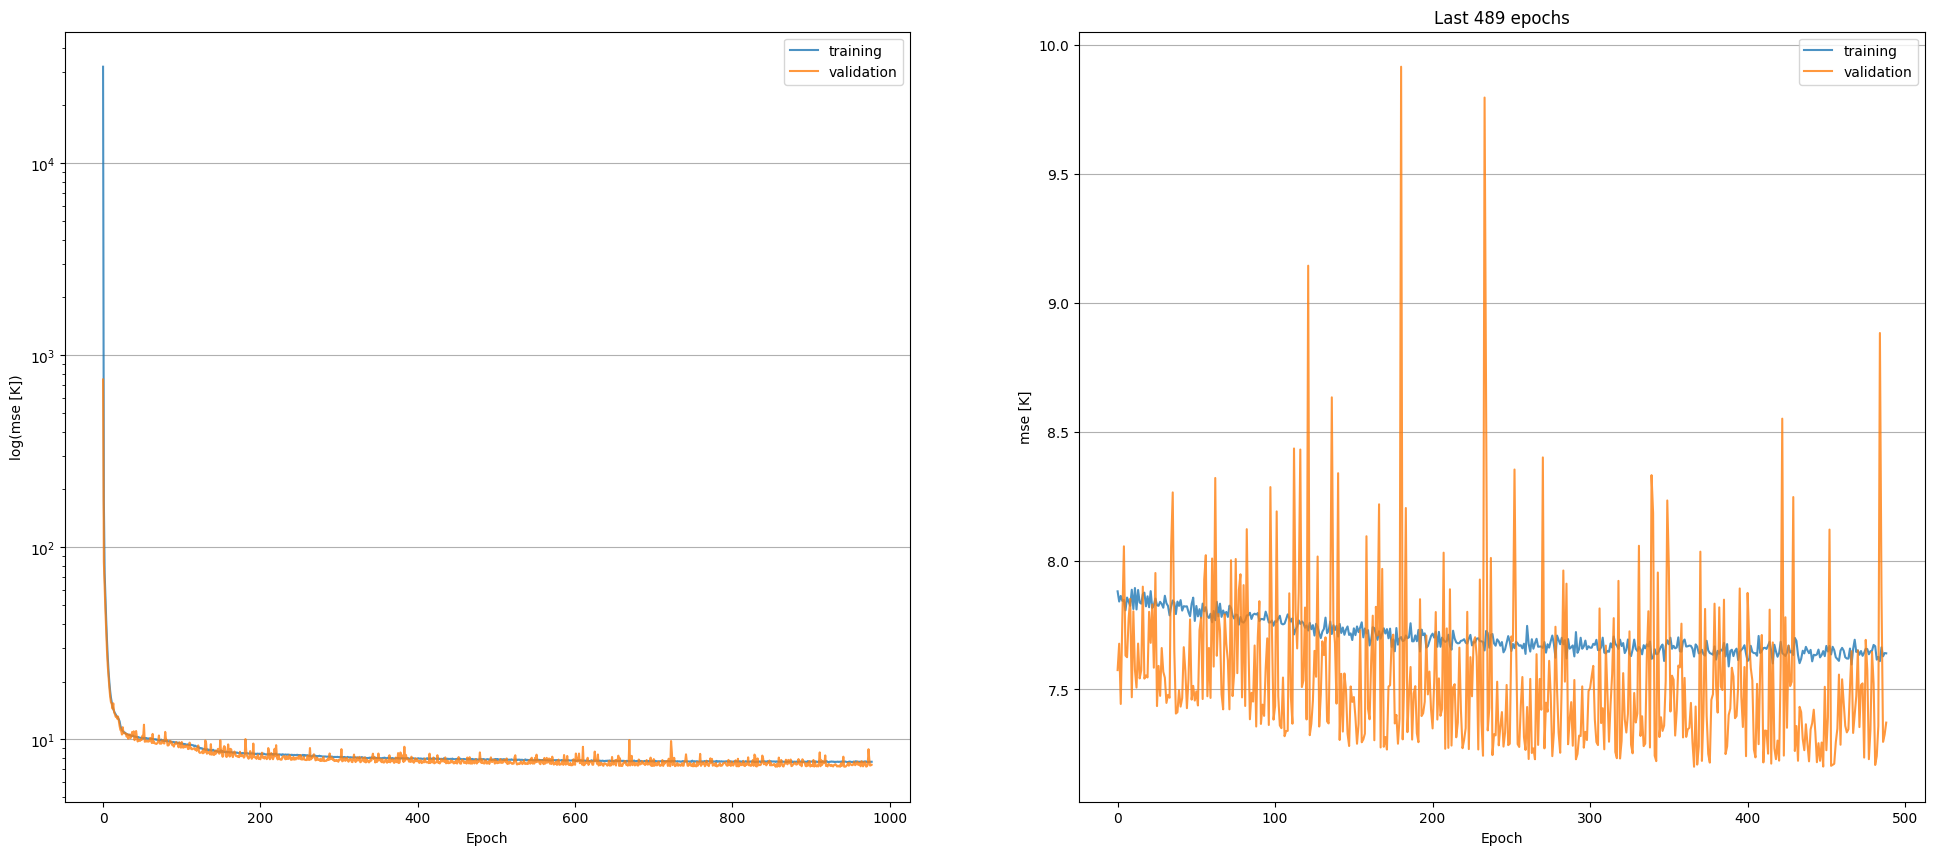

In [12]:
plot_history(history.history)

(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='log(mse [K])'>,
        <Axes: title={'center': 'Last 72 epochs'}, xlabel='Epoch', ylabel='mse [K]'>],
       dtype=object))

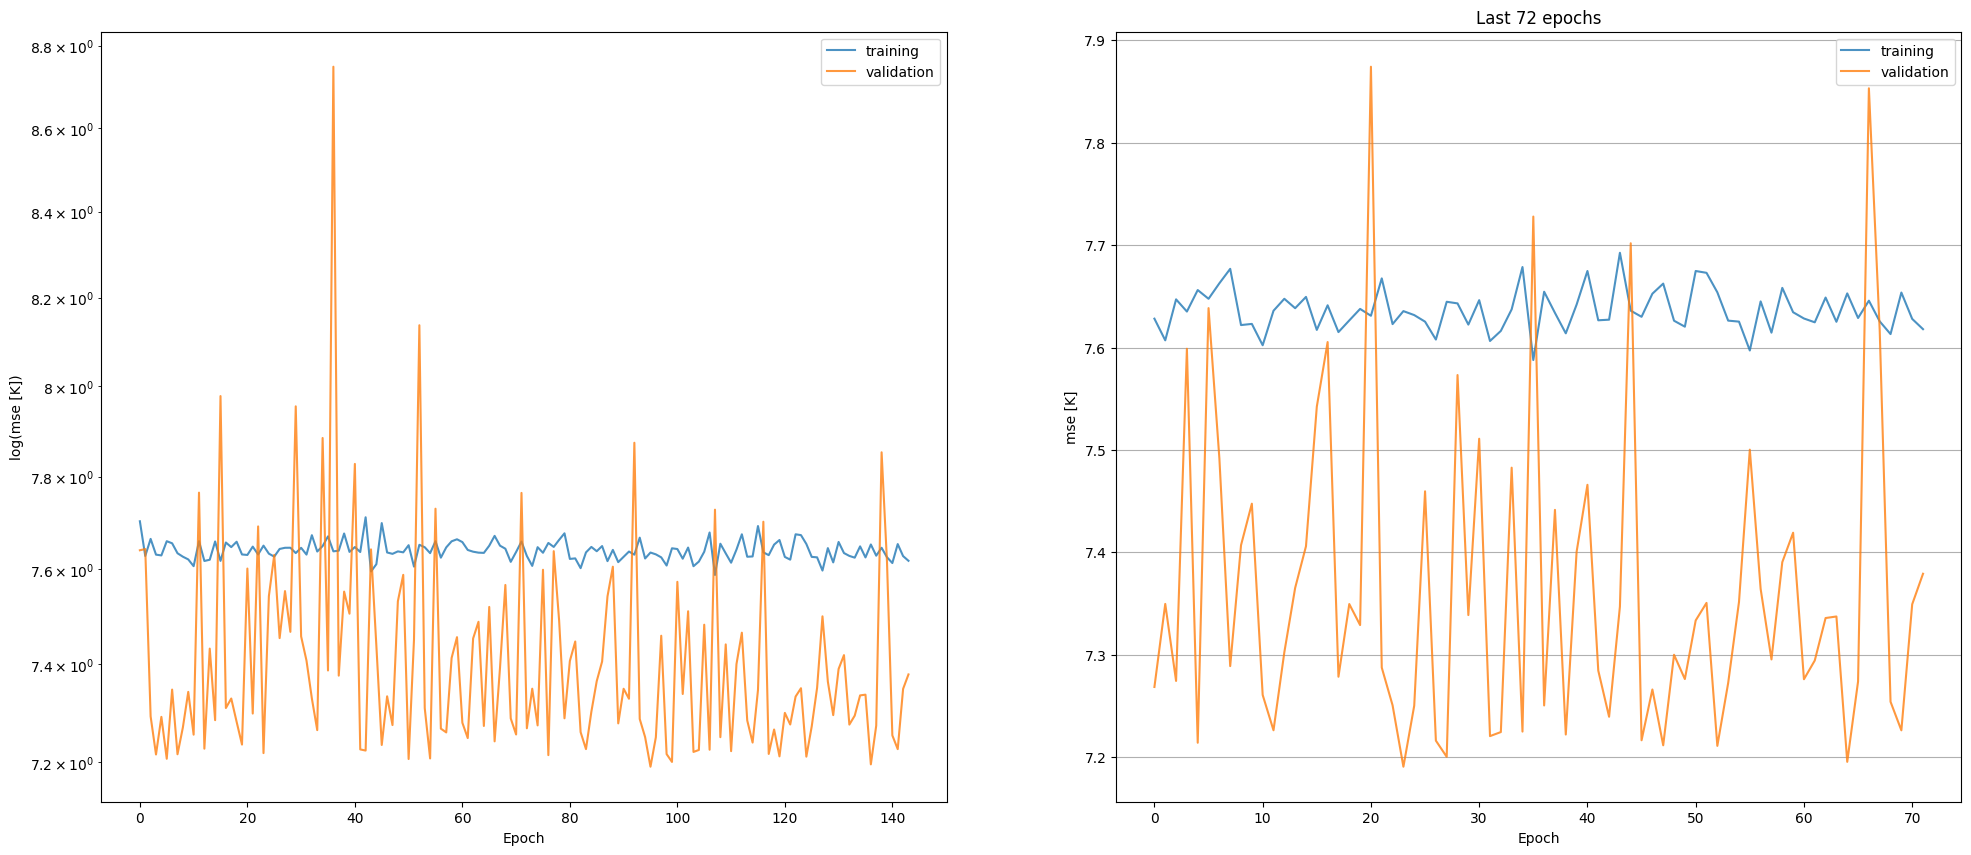

In [15]:
plot_history(history.history)

In [16]:
model_path = "../../models/local_winsat_emissv2_1b.keras"
save_model(model, model_path)

# Save the training history:
history_path = "../../models/local_winsat_emissv2_1b_history"
with open(history_path,"wb") as hfile:
    pickle.dump(history.history, hfile)